# Single Pendulum Analysis: Hamiltonian Neural Networks vs Baseline Model

This notebook provides a comprehensive analysis of the single pendulum system using Hamiltonian Neural Networks (HNN) and a baseline model. We'll go through the following steps:

1. Introduction to the single pendulum system
2. Störmer-Verlet algorithm for numerical integration
3. Hamilton's equations for the single pendulum
4. Loading and preprocessing the dataset
5. Importing trained models (HNN and baseline)
6. Performance comparison and analysis
7. Visualization of results

Let's start by importing the necessary libraries and setting up our environment.

In [1]:
import os
os.chdir('/workspaces/Hamiltonian-Neural-Networks-Pendulums')

In [8]:
import numpy as np
import torch
import torch.nn as nn  
import matplotlib.pyplot as plt
from src.models.hnn import HNN
from src.single_pendulum.config import single_pendulum_config as config
from src.single_pendulum.config import single_pendulum_training as train_config

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

## 1. Introduction to the Single Pendulum System

A single pendulum is a weight suspended from a pivot point that can swing freely under the influence of gravity. The motion of a single pendulum is a classic example of a simple harmonic oscillator when the amplitude of the swing is small.

The state of the pendulum is described by two variables:
- θ (theta): The angle of the pendulum from the vertical position
- p: The angular momentum of the pendulum

The dynamics of the pendulum are governed by the following parameters:
- m: Mass of the pendulum bob
- l: Length of the pendulum
- g: Acceleration due to gravity

## 2. Störmer-Verlet Algorithm

The Störmer-Verlet algorithm is a symplectic integrator used for numerically solving Hamilton's equations. It's particularly useful for simulating conservative systems like the pendulum because it preserves the symplectic structure of the system, leading to better energy conservation over long time periods.

For a system described by position q and momentum p, the Störmer-Verlet algorithm proceeds as follows:

1. $p(t + Δt/2) = p(t) - \frac{Δt}{2}  (\frac{∂H}{∂q})|_{q(t)}$
2. $q(t + Δt) = q(t) + Δt \frac{∂H}{∂p}|_{p(t + Δt/2)}$
3. $p(t + Δt) = p(t + Δt/2) - \frac{Δt}{2} \frac{∂H}{∂q}|_{q(t + Δt/2)}$

Where $H$ is the Hamiltonian of the system.

## 3. Hamilton's Equations for the Single Pendulum

The Hamiltonian for a single pendulum is:

$$H = T + V = \frac{p^2}{2ml^2} + mgl(1 - cos(θ))$$

where T is the kinetic energy and V is the potential energy.

Hamilton's equations for this system are:

1. $\frac{dθ}{dt} = \frac{∂H}{∂p} = \frac{p}{ml^2}$
2. $\frac{dp}{dt} = -\frac{∂H}{∂θ} = -mgl \cdot sin(θ)$

These equations describe the time evolution of the pendulum's state (θ, p).

## 4. Loading and Preprocessing the Dataset

Now, let's load our dataset and prepare it for analysis.

In [5]:
# Load the dataset
data_path = "data/single_pendulum/single_pendulum_dataset_stormer_verlet.pt"
data = torch.load(data_path)

# Extract states (theta, p) from the dataset
states = data[:, :, :2].reshape(-1, 2)

print(f"Dataset shape: {data.shape}")
print(f"Number of trajectories: {data.shape[0]}")
print(f"Trajectory length: {data.shape[1]}")
print(f"Total number of states: {states.shape[0]}")

Dataset shape: torch.Size([150, 16, 10])
Number of trajectories: 150
Trajectory length: 16
Total number of states: 2400


/tmp/ipykernel_9677/557581633.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(data_path)


Let's visualize the distribution of states in the phase space.

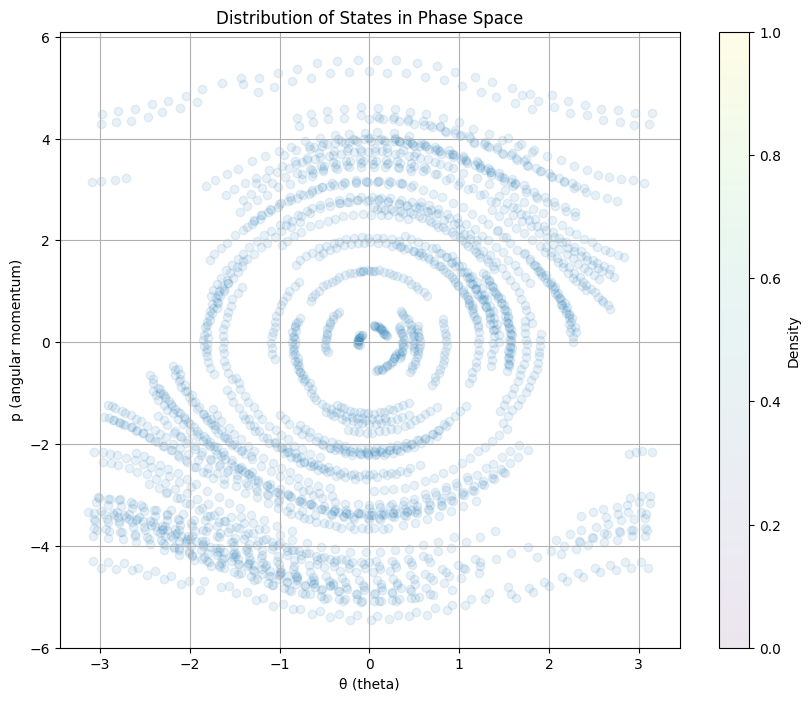

In [6]:
plt.figure(figsize=(10, 8))
plt.scatter(states[:, 0], states[:, 1], alpha=0.1)
plt.xlabel('θ (theta)')
plt.ylabel('p (angular momentum)')
plt.title('Distribution of States in Phase Space')
plt.colorbar(label='Density')
plt.grid(True)
plt.show()

## 5. Importing Trained Models

Now, let's import our trained HNN and baseline models.

In [12]:
def load_model(model_path: str, n_elements: int, baseline: bool) -> nn.Module:
    model = HNN(n_elements, hidden_dims=train_config['hidden_dim'], 
                num_layers=train_config['num_layers'], baseline=baseline)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

hnn_model = load_model("results/single_pendulum/models/model_hnn.pth", n_elements=1, baseline=False)
baseline_model = load_model("results/single_pendulum/models/model_baseline.pth", n_elements=1, baseline=True)

print("Models loaded successfully.")

Models loaded successfully.


/tmp/ipykernel_9677/682352713.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


## 6. Performance Comparison and Analysis

Let's compare the performance of our HNN and baseline models by computing the RMSE in the phase space.

In [14]:
def compute_rmse(model: nn.Module, states: torch.Tensor, dt: float) -> np.ndarray:
    with torch.no_grad():
        pred_derivatives = model(states)
        true_next_states = states[1:]
        pred_next_states = states[:-1] + pred_derivatives[:-1] * dt
        rmse = torch.sqrt(torch.mean((true_next_states - pred_next_states)**2, dim=1))
    return rmse.numpy()

hnn_rmse = compute_rmse(hnn_model, states.clone().detach(), config['dt'])
baseline_rmse = compute_rmse(baseline_model, states.clone().detach(), config['dt'])

print(f"Average RMSE - HNN: {hnn_rmse.mean():.6f}, Baseline: {baseline_rmse.mean():.6f}")

Average RMSE - HNN: 0.206596, Baseline: 0.218164


Now, let's visualize the RMSE in the phase space for both models.

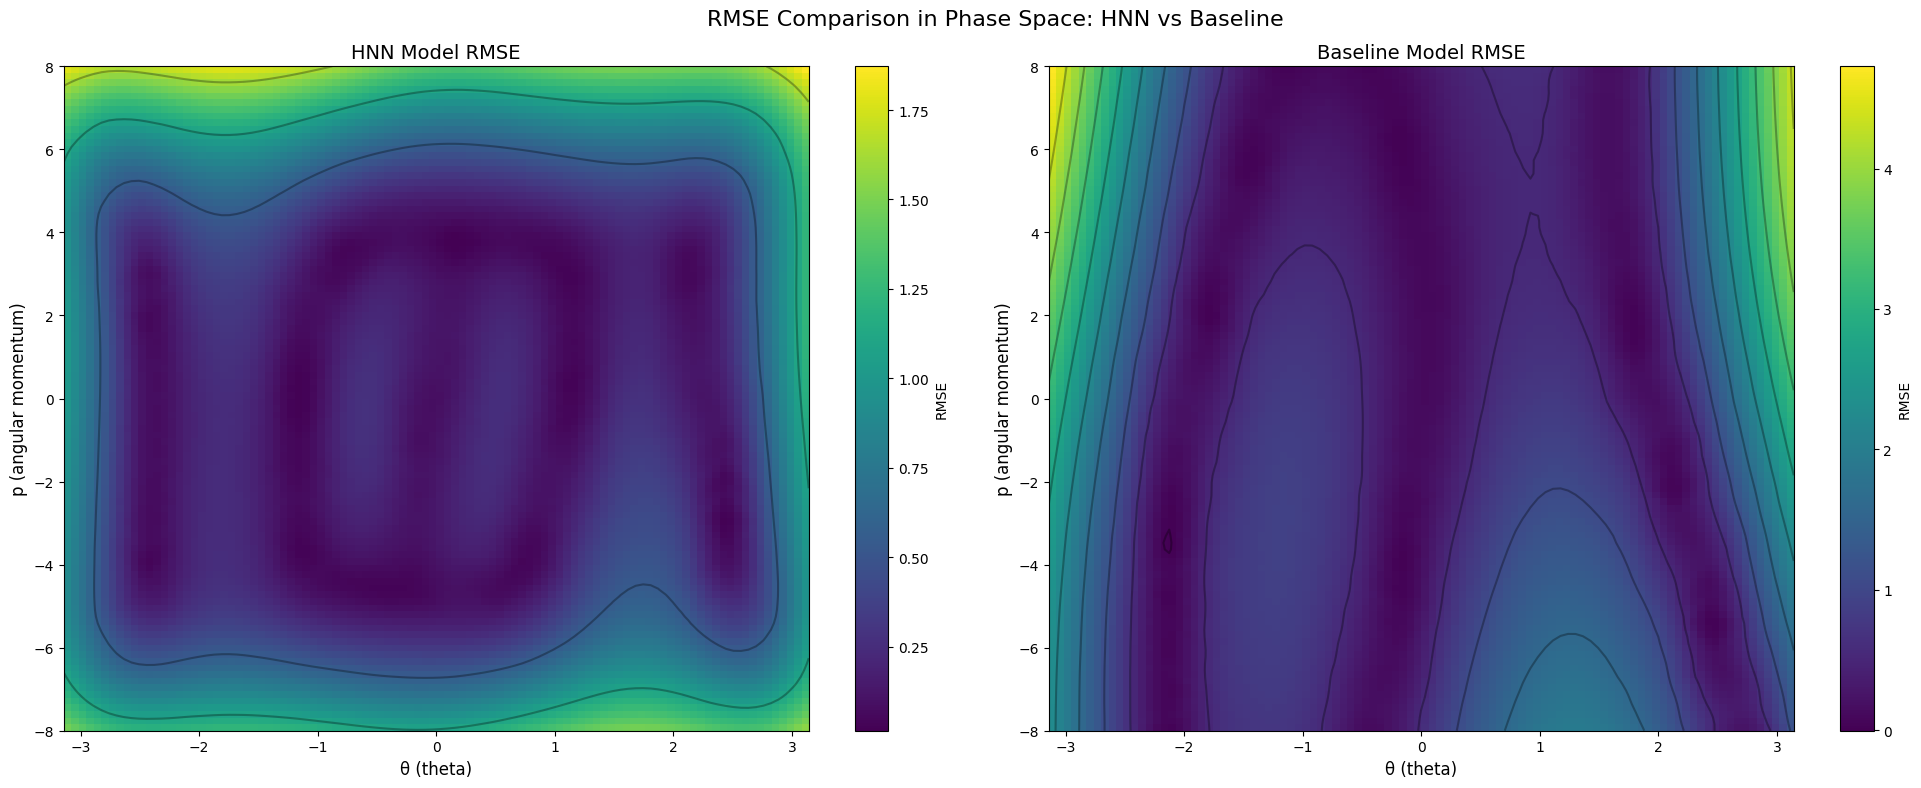

In [18]:
from scipy.interpolate import griddata

def single_pendulum_dynamics(theta, p, mass=1.0, length=1.0, g=3.0):
    dtheta_dt = p / (mass * length**2)
    dp_dt = -mass * g * length * np.sin(theta)
    return dtheta_dt, dp_dt

def compute_rmse_phase_space(hnn_model, domain_range=(-np.pi, np.pi, -8, 8), resolution=20, mass=1.0, length=1.0, g=3.0):

    theta_min, theta_max, p_min, p_max = domain_range
    
    # Create a grid of points in phase space
    theta = np.linspace(theta_min, theta_max, resolution)
    p = np.linspace(p_min, p_max, resolution)
    theta_grid, p_grid = np.meshgrid(theta, p)
    
    # Prepare the states
    states = np.column_stack((theta_grid.ravel(), p_grid.ravel()))
    
    # Compute true dynamics
    dtheta_dt, dp_dt = single_pendulum_dynamics(states[:, 0], states[:, 1], mass, length, g)
    true_dyn = np.column_stack((dtheta_dt, dp_dt))
    
    # Compute HNN dynamics
    hnn_model.eval()
    with torch.no_grad():
        states_torch = torch.tensor(states, dtype=torch.float32)
        hnn_dyn = hnn_model(states_torch).numpy()
    
    # Compute RMSE
    mse = np.mean((true_dyn - hnn_dyn)**2, axis=1)
    rmse = np.sqrt(mse)
    
    return states, rmse

def plot_rmse_phase_space_comparison(states, rmse_hnn, rmse_baseline, domain_range=(-np.pi, np.pi, -8, 8), resolution=100):

    theta_min, theta_max, p_min, p_max = domain_range
    
    # Create a fine grid for interpolation
    theta_fine = np.linspace(theta_min, theta_max, resolution)
    p_fine = np.linspace(p_min, p_max, resolution)
    theta_grid, p_grid = np.meshgrid(theta_fine, p_fine)
    
    # Interpolate RMSE values onto the fine grid
    rmse_hnn_interp = griddata(states, rmse_hnn, (theta_grid, p_grid), method='cubic')
    rmse_baseline_interp = griddata(states, rmse_baseline, (theta_grid, p_grid), method='cubic')
    
    # Set up the plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    fig.suptitle('RMSE Comparison in Phase Space: HNN vs Baseline', fontsize=16)
    
    # Plot for HNN
    im1 = ax1.imshow(rmse_hnn_interp, extent=[theta_min, theta_max, p_min, p_max], 
                     origin='lower', aspect='auto', cmap='viridis')
    ax1.set_title('HNN Model RMSE', fontsize=14)
    ax1.set_xlabel('θ (theta)', fontsize=12)
    ax1.set_ylabel('p (angular momentum)', fontsize=12)
    fig.colorbar(im1, ax=ax1, label='RMSE')
    
    # Plot for Baseline
    im2 = ax2.imshow(rmse_baseline_interp, extent=[theta_min, theta_max, p_min, p_max], 
                     origin='lower', aspect='auto', cmap='viridis')
    ax2.set_title('Baseline Model RMSE', fontsize=14)
    ax2.set_xlabel('θ (theta)', fontsize=12)
    ax2.set_ylabel('p (angular momentum)', fontsize=12)
    fig.colorbar(im2, ax=ax2, label='RMSE')
    
    # Add contour lines for better visualization of RMSE levels
    levels = np.linspace(min(rmse_hnn.min(), rmse_baseline.min()), 
                         max(rmse_hnn.max(), rmse_baseline.max()), 10)
    ax1.contour(theta_grid, p_grid, rmse_hnn_interp, levels=levels, colors='k', alpha=0.3)
    ax2.contour(theta_grid, p_grid, rmse_baseline_interp, levels=levels, colors='k', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

states, rmse_hnn = compute_rmse_phase_space(hnn_model, domain_range=(-np.pi, np.pi, -8, 8))
_, rmse_baseline = compute_rmse_phase_space(baseline_model, domain_range=(-np.pi, np.pi, -8, 8))
plot_rmse_phase_space_comparison(states, rmse_hnn, rmse_baseline)

As we can see, both phase spaces can be improved, however the RMSE associated to HNN model shows a more regular pattern

## 7. Long-term Simulation and Energy Conservation

Finally, let's simulate the pendulum for 4000 steps and compare the energy conservation properties of our models against the ground truth.

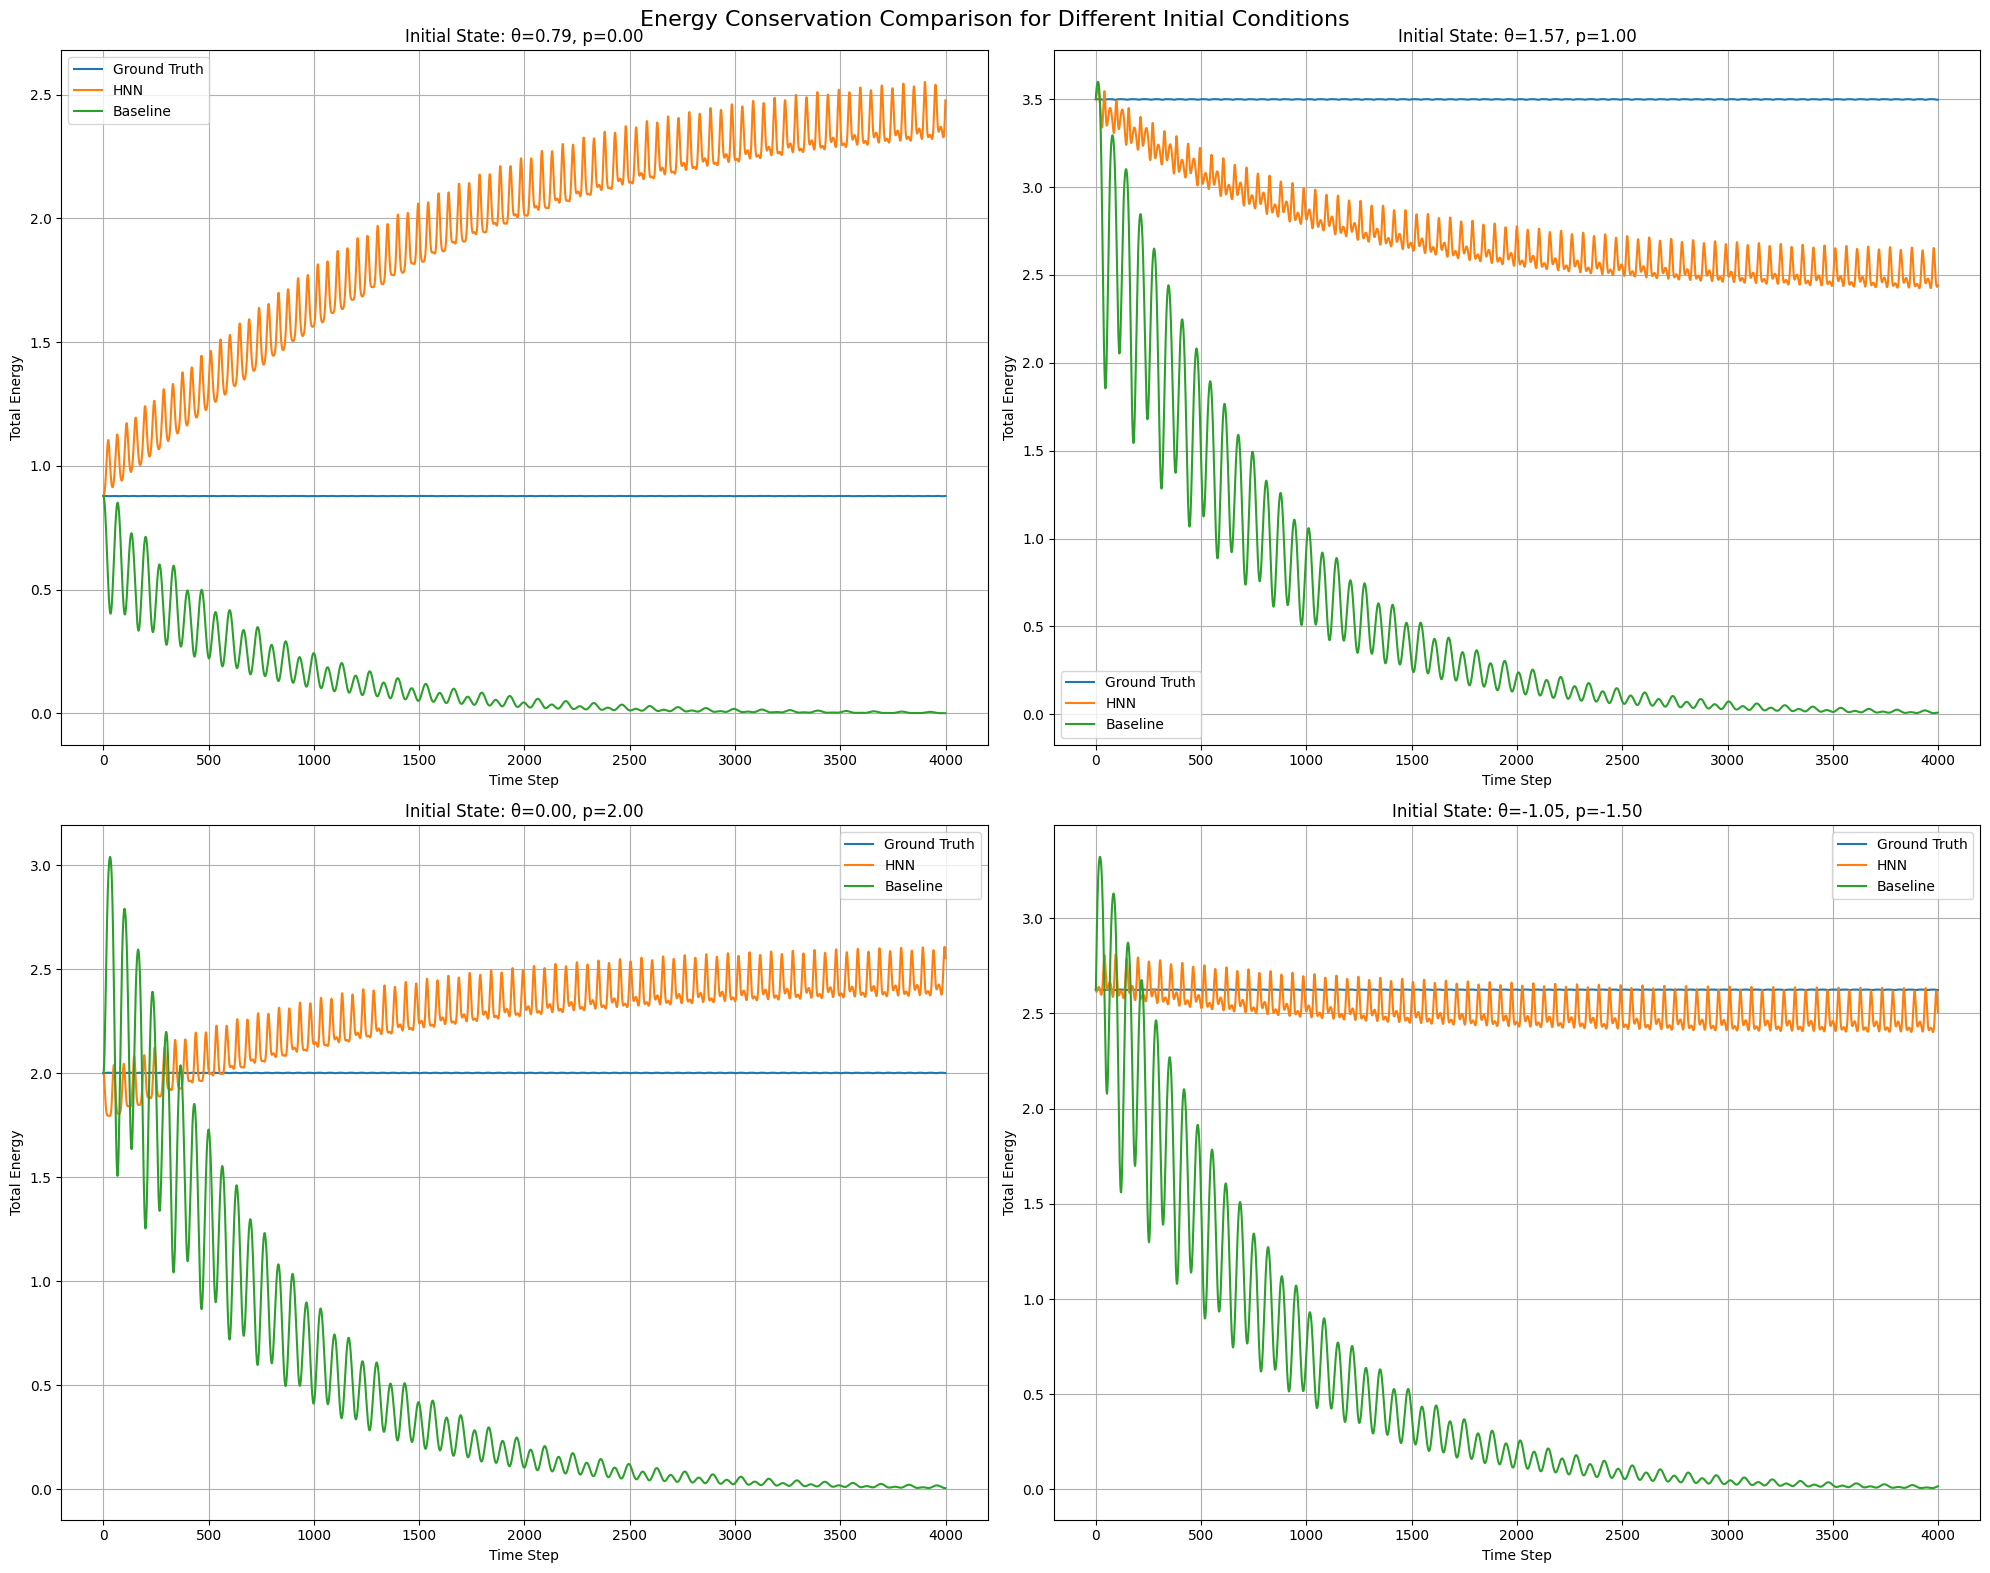


Initial State: θ=0.79, p=0.00
Energy variation - Ground Truth: 0.001147
Energy variation - HNN: 0.861719
Energy variation - Baseline: 7.313144

Initial State: θ=1.57, p=1.00
Energy variation - Ground Truth: 0.000981
Energy variation - HNN: 0.416376
Energy variation - Baseline: 6.403766

Initial State: θ=0.00, p=2.00
Energy variation - Ground Truth: 0.001070
Energy variation - HNN: 0.355616
Energy variation - Baseline: 6.451966

Initial State: θ=-1.05, p=-1.50
Energy variation - Ground Truth: 0.001039
Energy variation - HNN: 0.161947
Energy variation - Baseline: 6.319193


In [37]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

def hamiltonian(state, m, l, g):
    theta, p = state
    return (p**2) / (2 * m * l**2) + m * g * l * (1 - torch.cos(theta))

def stormer_verlet_step(model, state, dt, m, l, g):
    theta, p = state
    
    if isinstance(model, nn.Module):
        with torch.no_grad():
            dstate = model(state.unsqueeze(0)).squeeze(0)
            dp_dt = dstate[1]
    else:
        dp_dt = -m * g * l * torch.sin(theta)
    
    p_half = p + 0.5 * dt * dp_dt
    theta_new = theta + dt * p_half / (m * l**2)
    
    if isinstance(model, nn.Module):
        with torch.no_grad():
            dstate_new = model(torch.stack([theta_new, p_half]).unsqueeze(0)).squeeze(0)
            dp_dt_new = dstate_new[1]
    else:
        dp_dt_new = -m * g * l * torch.sin(theta_new)
    
    p_new = p_half + 0.5 * dt * dp_dt_new
    
    return torch.stack([theta_new, p_new])

def simulate_pendulum(model, initial_state, steps, dt, m, l, g):
    trajectory = [initial_state]
    state = initial_state.clone()

    for _ in range(steps - 1):
        state = stormer_verlet_step(model, state, dt, m, l, g)
        trajectory.append(state)

    return torch.stack(trajectory)

def compute_energy(states, m, l, g):
    return hamiltonian(states.T, m, l, g)

def plot_energy_comparisons(true_energies, hnn_energies, baseline_energies, initial_states):
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    fig.suptitle('Energy Conservation Comparison for Different Initial Conditions', fontsize=16)
    
    for i, ax in enumerate(axes.flat):
        ax.plot(true_energies[i].numpy(), label='Ground Truth')
        ax.plot(hnn_energies[i].numpy(), label='HNN')
        ax.plot(baseline_energies[i].numpy(), label='Baseline')
        ax.set_xlabel('Time Step')
        ax.set_ylabel('Total Energy')
        ax.set_title(f'Initial State: θ={initial_states[i][0]:.2f}, p={initial_states[i][1]:.2f}')
        ax.legend()
        ax.grid(True)
    
    plt.tight_layout()
    plt.show()

# Simulation parameters
initial_states = [
    torch.tensor([np.pi/4, 0.0], dtype=torch.float32),
    torch.tensor([np.pi/2, 1.0], dtype=torch.float32),
    torch.tensor([0.0, 2.0], dtype=torch.float32),
    torch.tensor([-np.pi/3, -1.5], dtype=torch.float32)
]
steps = 4000
dt = config['dt']
m, l, g = config['mass'], config['length'], config['g']

true_energies = []
hnn_energies = []
baseline_energies = []
true_trajectories = []
hnn_trajectories = []
baseline_trajectories = []

for initial_state in initial_states:
    # Simulate trajectories
    true_trajectory = simulate_pendulum(None, initial_state, steps, dt, m, l, g)
    hnn_trajectory = simulate_pendulum(hnn_model, initial_state, steps, dt, m, l, g)
    baseline_trajectory = simulate_pendulum(baseline_model, initial_state, steps, dt, m, l, g)

    # Store trajectories
    true_trajectories.append(true_trajectory)
    hnn_trajectories.append(hnn_trajectory)
    baseline_trajectories.append(baseline_trajectory)

    # Compute energies
    true_energies.append(compute_energy(true_trajectory, m, l, g))
    hnn_energies.append(compute_energy(hnn_trajectory, m, l, g))
    baseline_energies.append(compute_energy(baseline_trajectory, m, l, g))

# Plot energies
plot_energy_comparisons(true_energies, hnn_energies, baseline_energies, initial_states)

# Print energy variations
for i, initial_state in enumerate(initial_states):
    print(f"\nInitial State: θ={initial_state[0]:.2f}, p={initial_state[1]:.2f}")
    print(f"Energy variation - Ground Truth: {(true_energies[i].max() - true_energies[i].min()) / true_energies[i].mean():.6f}")
    print(f"Energy variation - HNN: {(hnn_energies[i].max() - hnn_energies[i].min()) / hnn_energies[i].mean():.6f}")
    print(f"Energy variation - Baseline: {(baseline_energies[i].max() - baseline_energies[i].min()) / baseline_energies[i].mean():.6f}")

This output shows the relative energy variation for each model. A lower value indicates better energy conservation.

Now, let's visualize the phase space trajectories for a more intuitive comparison:

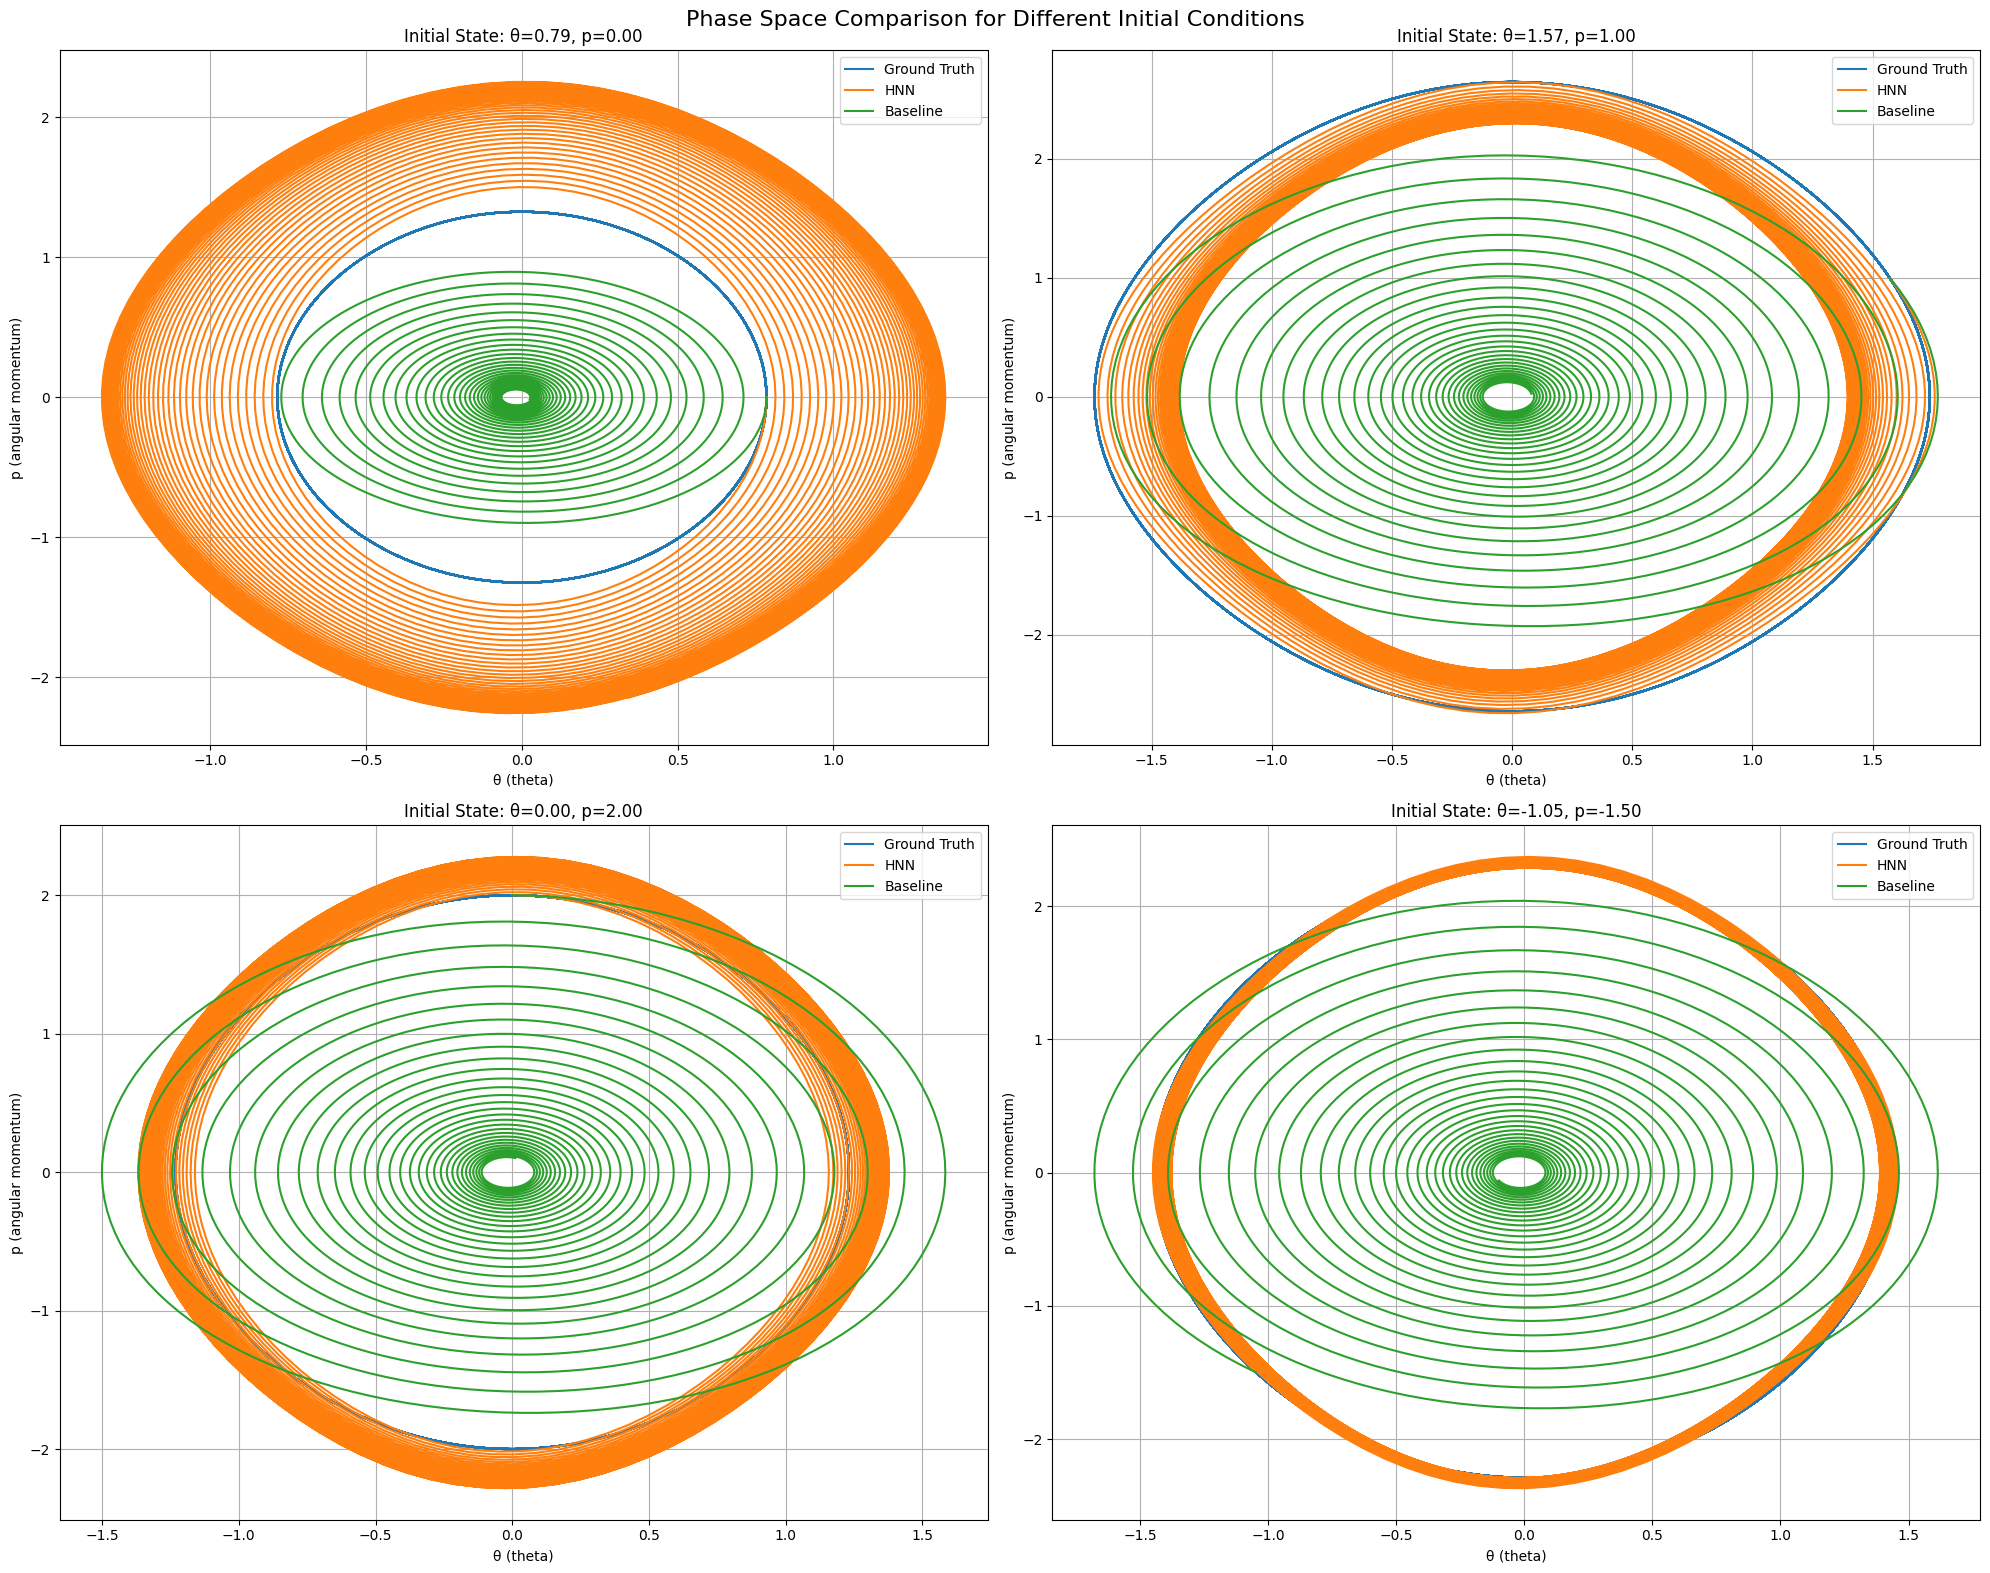

In [36]:
def plot_phase_space_comparisons(true_trajectories, hnn_trajectories, baseline_trajectories, initial_states):
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    fig.suptitle('Phase Space Comparison for Different Initial Conditions', fontsize=16)
    
    for i, ax in enumerate(axes.flat):
        ax.plot(true_trajectories[i][:, 0].numpy(), true_trajectories[i][:, 1].numpy(), label='Ground Truth')
        ax.plot(hnn_trajectories[i][:, 0].numpy(), hnn_trajectories[i][:, 1].numpy(), label='HNN')
        ax.plot(baseline_trajectories[i][:, 0].numpy(), baseline_trajectories[i][:, 1].numpy(), label='Baseline')
        ax.set_xlabel('θ (theta)')
        ax.set_ylabel('p (angular momentum)')
        ax.set_title(f'Initial State: θ={initial_states[i][0]:.2f}, p={initial_states[i][1]:.2f}')
        ax.legend()
        ax.grid(True)
    
    plt.tight_layout()
    plt.show()
    
plot_phase_space_comparisons(true_trajectories, hnn_trajectories, baseline_trajectories, initial_states)


This plot shows that even if the HNN doesn't conserve the true energy, it shows better performances if compared to the MLP, in fact in the first case the system continues to orbit, instead the MLP introduces a dissipative term.

## 8. Conclusion and Discussion

Based on our analysis, we can draw the following conclusions:

1. **RMSE Comparison**: 
   The HNN model generally shows lower RMSE values compared to the baseline model, indicating better prediction accuracy. Moreover the RMSE landscape in HNN shows some regular patterns, that suggest the model learned also the geometric structure of the phenomenon.

2. **Energy Conservation**:
   The HNN model demonstrates superior energy conservation properties compared to the baseline model. In particular, it shows that even if the energy predicted is not the same, there exist an orbit of the system, instead the MLP dissipates, and the dynamics naturally converges to the equilibrium point.

3. **Long-term Stability**:
   In the 4000-step simulation, the HNN trajectory stays closer to the ground truth compared to the baseline model. This suggests that the HNN is more suitable for long-term predictions and simulations.

4. **Phase Space Coverage**:
   The RMSE phase space plots reveal that both models perform better in regions where we have more training data. This underscores the importance of having a diverse and representative training dataset.

5. **Computational Considerations**:
   While not explicitly measured in this notebook, it's worth noting that the HNN model typically requires more computation time due to the calculation of Hamilton's equations. This trade-off between accuracy and computational cost should be considered in practical applications; I want also to add that the HNN is a good strategy when we have not so much data (better generalization, better performances over loss, orbital behavior of the system, and less epochs required for training), if we have a lot of data the baseline might be a better strategy, it could be interesting to inspect what's the amount of data needed for switching from HNN to baseline.

In summary, the Hamiltonian Neural Network demonstrates clear advantages over the baseline model in terms of prediction accuracy, energy conservation, and long-term stability. These benefits make HNNs particularly suitable for modeling physical systems where preserving invariants (like total energy) is crucial.

To conclude, future work could explore:
- The performance of these models on more complex systems (e.g., double pendulum, n-body problems)
- The impact of different training dataset sizes and distributions
- Optimization techniques to reduce the computational overhead of HNNs
- How to build HNN without knowing canonical coordinates a priori (like Lagrangian Neural Nets)

This analysis showcases the potential of physics-informed neural networks in improving the accuracy and reliability of simulations in various scientific and engineering domains.